In [25]:
from IPython.core.display import display, HTML # full-width cells
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Import and plot data
`cycles.csv` labels the cycle in which each data point belongs.

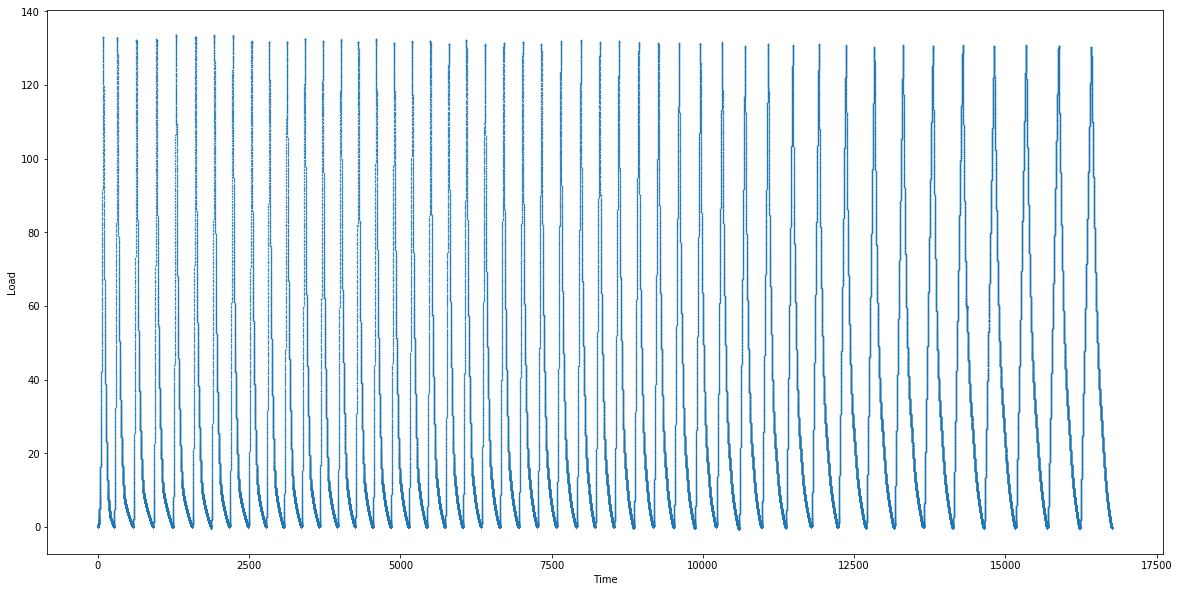

In [3]:
df = pd.read_csv('data/cycles.csv')
fig, axes = plt.subplots(figsize=(20,10))
sns.set()
sns.set_style('whitegrid')
sns.regplot('Time', 'Load', df, fit_reg=False, scatter_kws={'s': 2});

### Extrema behavior over time
Plots of minimum and maximum force (N) over all cycles.

In [4]:
from scipy.signal import argrelextrema
import statsmodels
pd.options.mode.chained_assignment = None  # ignore SettingWithCopyWarning

In [5]:
# TODO clean this up
minima_ind = argrelextrema(df['Load'].values, comparator=np.less, order=100)[0]
maxima_ind = argrelextrema(df['Load'].values, comparator=np.greater, order=100)[0]
time = pd.DataFrame(df['Time'].values[minima_ind]); time.columns = ['Time']
minima = pd.DataFrame(df['Load'].values[minima_ind]); minima.columns = ['MinLoad']; minima = time.join(minima)
maxima = pd.DataFrame(df['Load'].values[maxima_ind]); maxima.columns = ['MaxLoad']; maxima = time.join(maxima)

We choose robust OLS to ignore the maxima outlier at `Time=~1500`.

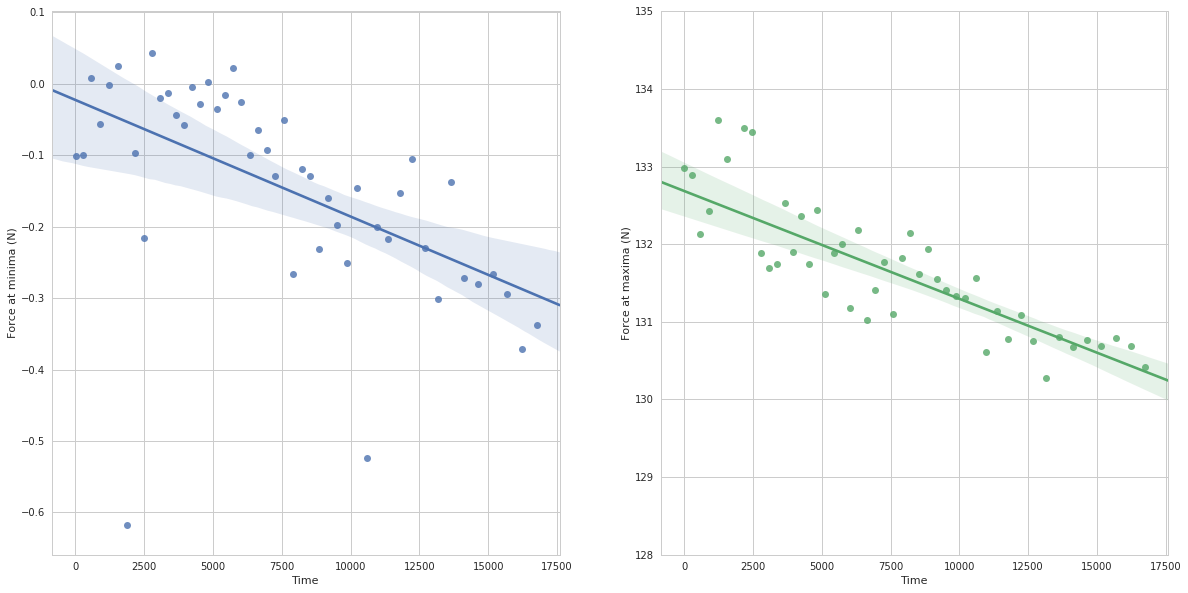

In [6]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20,10))
sns.regplot('Time', 'MinLoad', minima, ax=axes.flat[0]); axes[0].set(ylabel='Force at minima (N)')
axes.flat[1].set_ylim(128, 135)
sns.regplot('Time', 'MaxLoad', maxima, robust=True, ax=axes.flat[1]); axes[1].set(ylabel='Force at maxima (N)');

### Cycles overlaid over time

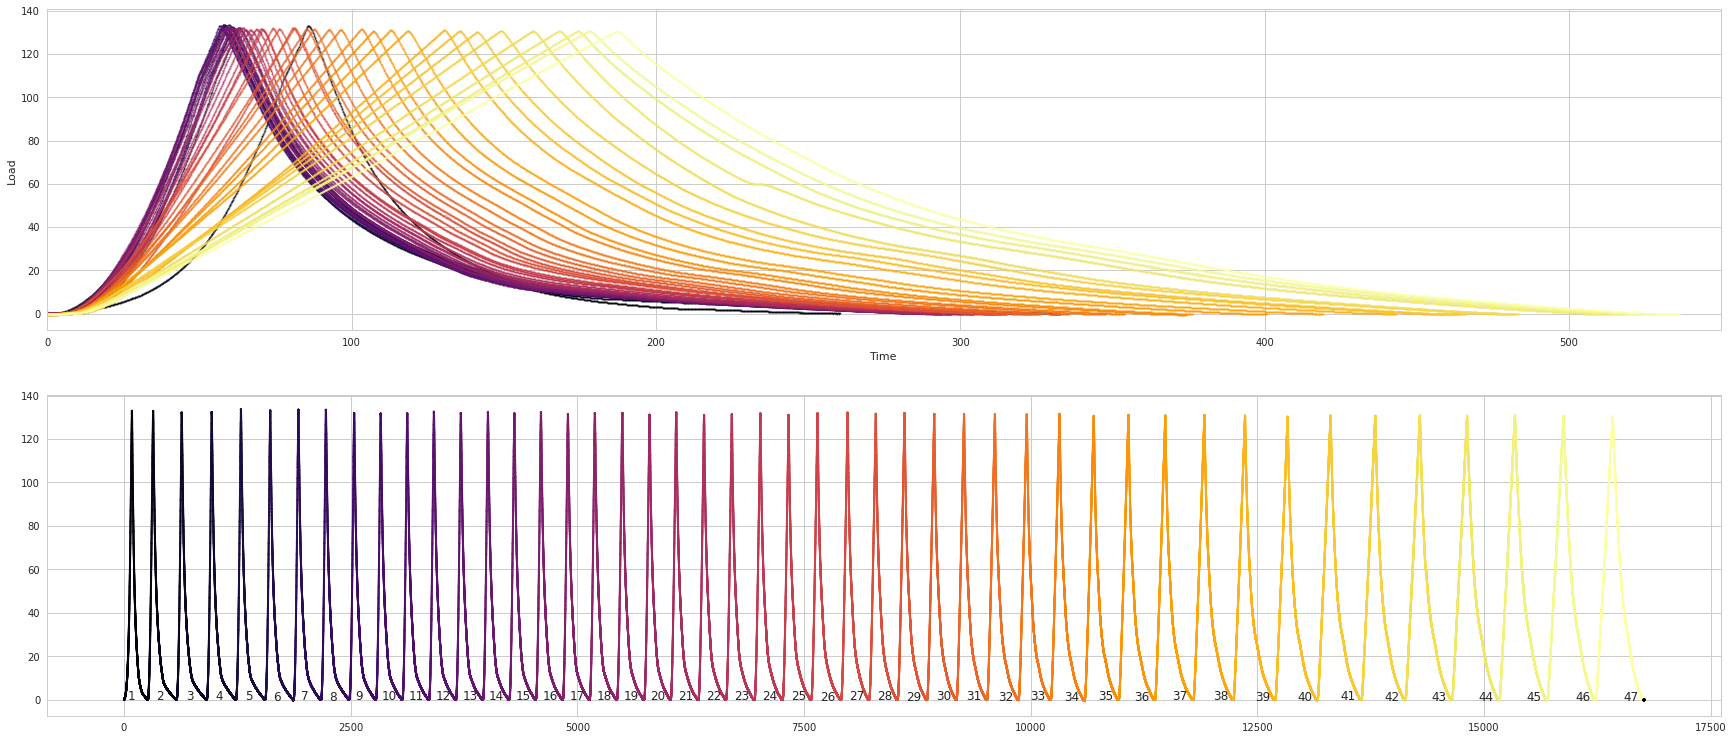

In [40]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(30,13)); axes.flat[0].set_xlim(0, 550)
cmap = plt.get_cmap('inferno') #axes.set_color_cycle(['red', 'black', 'yellow'])
colors = [cmap(i) for i in np.linspace(0, 1, df.Cycle.max())]
for cycle in range(df.Cycle.max()):
    zeroed_df = df[df.Cycle==cycle]
    zeroed_df.Time -= zeroed_df.Time.min() #zeroed_df.reset_index(drop=True, inplace=True)
    sns.regplot('Time', 'Load', zeroed_df, fit_reg=False, scatter=True, ax=axes.flat[0], scatter_kws={'s': 3, 'color': colors[cycle], 'alpha': 0.5})
axes.flat[1].scatter(df.Time, df.Load, s=3, c=df.Cycle, cmap=cmap);
for i, row in minima.iterrows():
    if i > 0:
        axes.flat[1].text(row['Time']-220, row['MinLoad'], str(i)) # hack to label cycles at bottom
#df.apply(lambda row: axes.flat[0].text(row.Time, row.Load, '%.1f'%(row.Cycle)),axis=1);

### Area under cycle curve, over time
We plot an OLS regression line for reference.

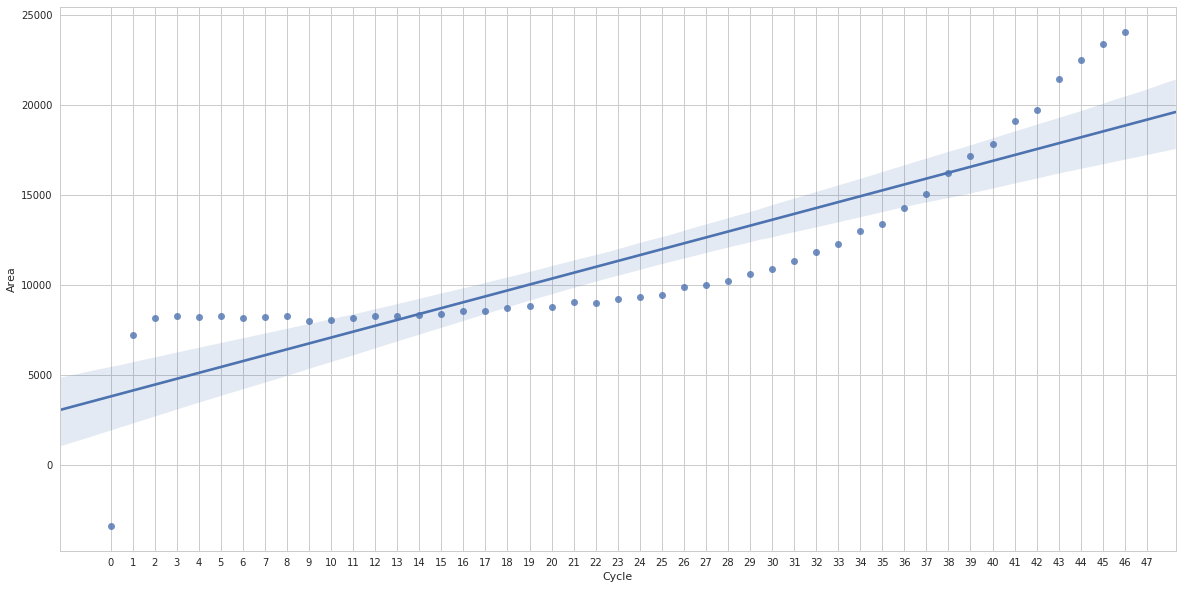

In [8]:
fig, axes = plt.subplots(figsize=(20,10))#; axes.flat[0].set_xlim(0, 550)
areas = np.zeros((df.Cycle.max(),))
for cycle in range(df.Cycle.max()):
    cycle_load = df[df.Cycle==cycle].Load.as_matrix()
    cycle_time = df[df.Cycle==cycle].Time.as_matrix()
    areas[cycle] = np.trapz(cycle_load, cycle_time)
areas_df = pd.DataFrame(areas); areas_df.columns = ['Area']; areas_df = areas_df.reset_index()
sns.regplot('index', 'Area', areas_df)
axes.set_xticks(np.arange(0, 48)); axes.set(xlabel='Cycle');

### Moment of area over time
We determine both 1st and 2nd moments of area.

In [9]:
from scipy.stats import moment

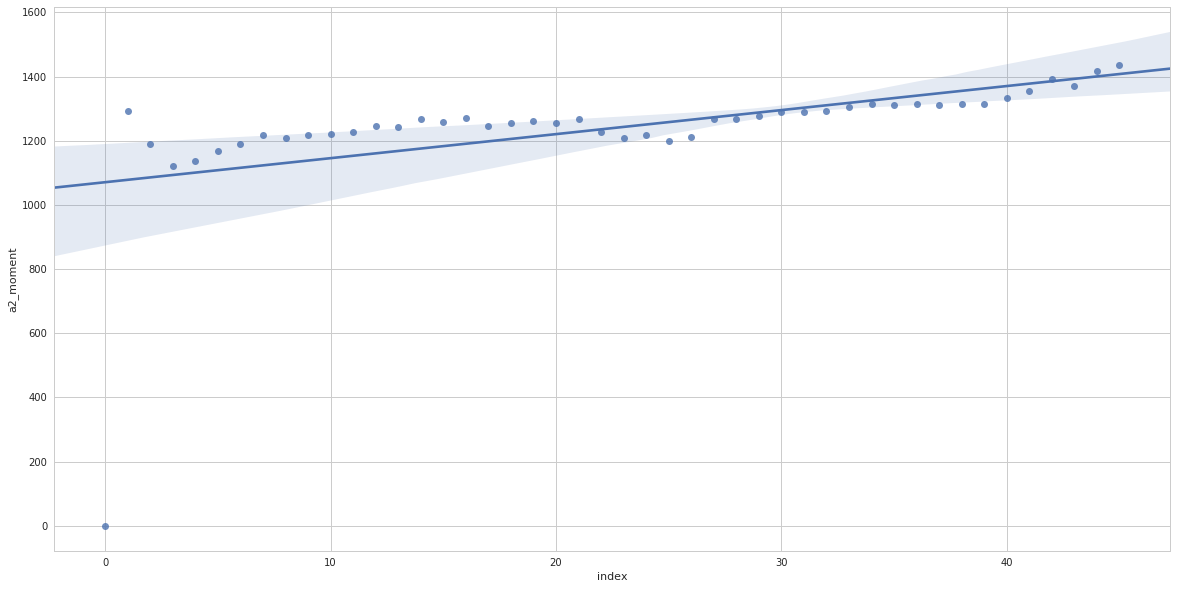

In [10]:
fig, axes = plt.subplots(figsize=(20,10))#; axes.flat[0].set_xlim(0, 550)
moments = np.zeros((df.Cycle.max()-1, 2))
for cycle in range(df.Cycle.max()-1):
    moments[cycle] = moment(df[df.Cycle==cycle].iloc[1:,:2].as_matrix(), moment=2)
moments_df = pd.DataFrame(moments); moments_df.columns = ['a1_moment', 'a2_moment']; moments_df = moments_df.reset_index()
sns.regplot('index', 'a2_moment', moments_df);

### Push minima, maxima, area, moment of area to a new dataset

In [42]:
area_df = pd.DataFrame(areas, columns=['Area'])
moa_df = pd.DataFrame(areas, columns=['Moment'])
meta_df = minima.merge(maxima, on='Time')
meta_df = meta_df.join(area_df).join(moa_df)
meta_df.drop(axis=0, index=0) # Ignore the Instron initialization cycle at t=1.7s

,Time,MinLoad,MaxLoad,Area,Moment
1,262.30000,-0.09963,132.89650,7194.644662,7194.644662
2,573.89994,0.00872,132.13715,8131.923440,8131.923440
3,906.69994,-0.05600,132.42795,8249.843636,8249.843636
4,1231.90000,-0.00150,133.59475,8198.216090,8198.216090
5,1555.70000,0.02537,133.09166,8274.709155,8274.709155
6,1864.00000,-0.61840,0.59495,8155.613543,8155.613543
7,2169.09975,-0.09700,133.49737,8190.082791,8190.082791
8,2478.00000,-0.21602,133.44473,8269.753392,8269.753392
9,2770.80000,0.04363,131.88279,8007.463053,8007.463053
10,3066.79975,-0.02033,131.69929,8066.478324,8066.478324
